# Visualization

In [1]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Loading Data File


In [2]:
path = "../Data/"
building = "avenal-animal-shelter"
interval = 5 # min


with open(path + building + "_training_data.pkl", 'r') as f:
    training_data = pickle.load(f)

with open(path + building + "_test_data.pkl", "r") as f:
    test_data = pickle.load(f)

# Include previous indoor temperature as t_last


In [3]:
def add_last_temperature_feature(data):
    """Adding a feature which specifies what the previous temperature was "dt" seconds before the current
    datasample. Since data does not need be continious, we need a loop.
    :param: pd.df with cols: "t_in", "dt" and needs to be sorted by time.
    returns pd.df with cols "t_last" added. """

    last_temps = []

    last_temp = None
    curr_time = data.index[0]
    for index, row in data.iterrows():

        if last_temp is None:
            last_temps.append(row["t_in"])  # so the feature will be zero instead
        else:
            last_temps.append(last_temp)

        if curr_time == index:
            last_temp = row["t_in"]
            curr_time += datetime.timedelta(minutes=row["dt"])
        else:
            last_temp = None
            curr_time = index + datetime.timedelta(minutes=row["dt"])

    data["t_last"] = np.array(last_temps)
    return data

training_data = add_last_temperature_feature(training_data)
test_data = add_last_temperature_feature(test_data)

training_data.head()

,action,action_duration,dt,previous_action,t_next,t_in,t_out,occ,zone_temperatureHVAC_Zone_Shelter_Corridor,t_last
time,,,,,,,,,,
2018-04-18 23:16:42+00:00,0.0,300.0s,5.0,NaN,69.5,69.483333,66.499700,0.0,69.499167,69.483333
2018-04-18 23:21:42+00:00,0.0,600.0s,5.0,NaN,69.5,69.500000,66.499700,0.0,69.485833,69.483333
2018-04-18 23:26:42+00:00,0.0,900.0s,5.0,NaN,69.5,69.500000,66.520546,0.0,69.460833,69.500000
2018-04-18 23:31:42+00:00,0.0,1200.0s,5.0,NaN,69.4,69.500000,66.583083,0.0,69.450000,69.500000
2018-04-18 23:36:42+00:00,0.0,1500.0s,5.0,NaN,69.5,69.400000,66.666466,0.0,69.450489,69.500000


# Preprocessing Data

Action features has values 0,1,2,3,4,5 which is transformed to values:
0 - no action
1 - heating
2 - cooling

Action is represnted as two separate features: action_heating and action_cooling, which holds value either 0(off) or 1(on).

Select the rows in datasets such that interval time is constant (5 minutes)

In [4]:
def fix_data(data, interval):
    """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
    converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
    don't have dt equal to interval.
    :param data:
    :param interval: float:minutes"""
    def f(x):
        if x == 0:
            return 0
        elif x == 2 or x == 5:
            return 2
        elif x ==1 or x == 3:
            return 1
        
    def h(x):
        if x == 1:
            return 1
        else:
            return 0
        
    def c(x):
        if x == 2:
            return 1
        else:
            return 0

    data["action"] = data["action"].map(f)
    data['action_heating'] = data["action"].map(h)
    data['action_cooling'] = data['action'].map(c)
    
    print data.head()

    return data, data[data["dt"] == interval]

# get preproccessed test and training data
org_training_data, training_data = fix_data(training_data, interval)
org_test_data, test_data = fix_data(test_data, interval)

                           action action_duration   dt  previous_action  \
time                                                                      
2018-04-18 23:16:42+00:00       0          300.0s  5.0              NaN   
2018-04-18 23:21:42+00:00       0          600.0s  5.0              NaN   
2018-04-18 23:26:42+00:00       0          900.0s  5.0              NaN   
2018-04-18 23:31:42+00:00       0         1200.0s  5.0              NaN   
2018-04-18 23:36:42+00:00       0         1500.0s  5.0              NaN   

                           t_next       t_in      t_out  occ  \
time                                                           
2018-04-18 23:16:42+00:00    69.5  69.483333  66.499700  0.0   
2018-04-18 23:21:42+00:00    69.5  69.500000  66.499700  0.0   
2018-04-18 23:26:42+00:00    69.5  69.500000  66.520546  0.0   
2018-04-18 23:31:42+00:00    69.4  69.500000  66.583083  0.0   
2018-04-18 23:36:42+00:00    69.5  69.400000  66.666466  0.0   

                         

# Action = Heating plot

In [5]:
heating_data = training_data[training_data['action_heating'] == 1]
heating_data.head()

,action,action_duration,dt,previous_action,t_next,t_in,t_out,occ,zone_temperatureHVAC_Zone_Shelter_Corridor,t_last,action_heating,action_cooling
time,,,,,,,,,,,,
2018-04-20 16:11:42+00:00,1,300.0s,5.0,0.0,67.4,67.0,56.767781,0.0,67.490460,66.966667,1,0
2018-04-20 16:16:42+00:00,1,600.0s,5.0,0.0,67.9,67.4,56.277664,0.0,67.891667,67.000000,1,0
2018-04-20 16:21:42+00:00,1,900.0s,5.0,0.0,68.0,67.9,55.388773,0.0,68.138966,67.400000,1,0
2018-04-20 16:26:42+00:00,1,1200.0s,5.0,0.0,68.2,68.0,55.485998,0.0,68.306264,67.900000,1,0
2018-04-20 16:31:42+00:00,1,1500.0s,5.0,0.0,68.3,68.2,57.555457,0.0,68.517299,68.000000,1,0


In [6]:
diff = heating_data['t_next'] - heating_data['t_in']
heating_df = pd.DataFrame({'t_in': heating_data['t_in'], 't_next': heating_data['t_next']}) 
heating_df.head()

,t_in,t_next
time,,
2018-04-20 16:11:42+00:00,67.0,67.4
2018-04-20 16:16:42+00:00,67.4,67.9
2018-04-20 16:21:42+00:00,67.9,68.0
2018-04-20 16:26:42+00:00,68.0,68.2
2018-04-20 16:31:42+00:00,68.2,68.3


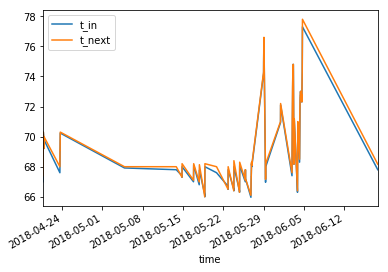

In [7]:
heating_df.plot()

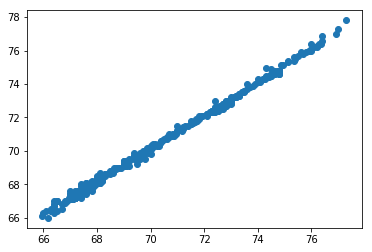

In [23]:
plt.scatter(heating_data['t_in'],heating_data['t_next'])

In [27]:
diff = heating_data['t_next'] - heating_data['t_in']

plt.scatter(heating_data['t_in'],diff)

NameError: name 'mean' is not defined

In [28]:
diff.describe()

count    446.000000
mean       0.111342
std        0.151289
min       -0.300000
25%        0.000000
50%        0.100000
75%        0.200000
max        0.633333
dtype: float64

# Action = Cooling plot


In [10]:
cooling_data = training_data[training_data['action_cooling'] == 1]
cooling_data.head()

,action,action_duration,dt,previous_action,t_next,t_in,t_out,occ,zone_temperatureHVAC_Zone_Shelter_Corridor,t_last,action_heating,action_cooling
time,,,,,,,,,,,,
2018-04-19 15:38:42+00:00,2,300.0s,5.0,0.0,66.900000,66.500000,52.298039,0.0,66.928333,66.4,0,1
2018-04-19 15:43:42+00:00,2,600.0s,5.0,0.0,67.000000,66.900000,52.527372,0.0,66.948333,66.5,0,1
2018-04-19 15:48:42+00:00,2,900.0s,5.0,0.0,66.900000,67.000000,52.434661,0.0,66.560000,66.9,0,1
2018-04-19 15:53:42+00:00,2,1200.0s,5.0,0.0,66.166667,66.900000,52.341950,0.0,66.034138,67.0,0,1
2018-04-19 16:15:42+00:00,2,300.0s,5.0,0.0,66.800000,66.533333,52.622372,0.0,66.780000,66.0,0,1


In [11]:
cooling_df = pd.DataFrame({'t_in': cooling_data['t_in'], 't_next': cooling_data['t_next']}) 
cooling_df.head()

,t_in,t_next
time,,
2018-04-19 15:38:42+00:00,66.500000,66.900000
2018-04-19 15:43:42+00:00,66.900000,67.000000
2018-04-19 15:48:42+00:00,67.000000,66.900000
2018-04-19 15:53:42+00:00,66.900000,66.166667
2018-04-19 16:15:42+00:00,66.533333,66.800000


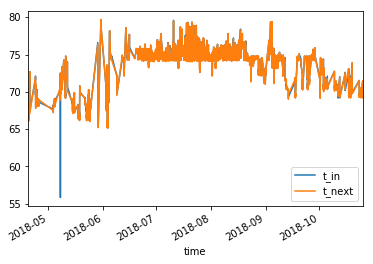

In [12]:
cooling_df.plot()

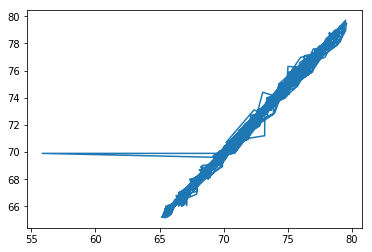

In [13]:
plt.plot(cooling_data['t_in'],cooling_data['t_next'])

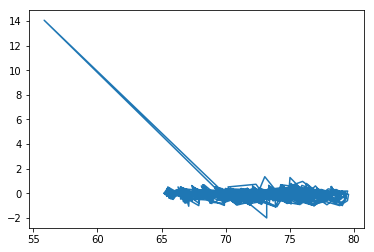

In [29]:
diff = cooling_data['t_next'] - cooling_data['t_in']
plt.plot(cooling_data['t_in'],diff)

In [30]:
diff.describe()

count    5766.000000
mean       -0.066056
std         0.308924
min        -2.000000
25%        -0.200000
50%        -0.100000
75%         0.100000
max        14.060000
dtype: float64

# Action = Nothing plot


In [15]:
no_action_data = training_data[training_data['action'] == 0]
no_action_data.head()

,action,action_duration,dt,previous_action,t_next,t_in,t_out,occ,zone_temperatureHVAC_Zone_Shelter_Corridor,t_last,action_heating,action_cooling
time,,,,,,,,,,,,
2018-04-18 23:16:42+00:00,0,300.0s,5.0,NaN,69.5,69.483333,66.499700,0.0,69.499167,69.483333,0,0
2018-04-18 23:21:42+00:00,0,600.0s,5.0,NaN,69.5,69.500000,66.499700,0.0,69.485833,69.483333,0,0
2018-04-18 23:26:42+00:00,0,900.0s,5.0,NaN,69.5,69.500000,66.520546,0.0,69.460833,69.500000,0,0
2018-04-18 23:31:42+00:00,0,1200.0s,5.0,NaN,69.4,69.500000,66.583083,0.0,69.450000,69.500000,0,0
2018-04-18 23:36:42+00:00,0,1500.0s,5.0,NaN,69.5,69.400000,66.666466,0.0,69.450489,69.500000,0,0


In [16]:
no_action_df = pd.DataFrame({'t_in': no_action_data['t_in'], 't_next': no_action_data['t_next']}) 
no_action_df.head()

,t_in,t_next
time,,
2018-04-18 23:16:42+00:00,69.483333,69.5
2018-04-18 23:21:42+00:00,69.500000,69.5
2018-04-18 23:26:42+00:00,69.500000,69.5
2018-04-18 23:31:42+00:00,69.500000,69.4
2018-04-18 23:36:42+00:00,69.400000,69.5


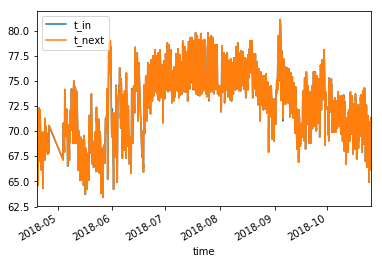

In [17]:
no_action_df.plot()

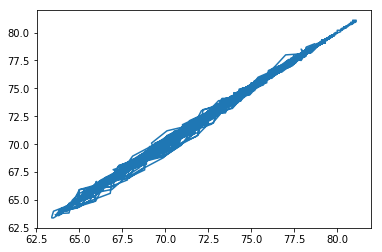

In [18]:
plt.plot(no_action_data['t_in'],no_action_data['t_next'])

count    4.353200e+04
mean     7.964418e-03
std      1.063513e-01
min     -1.200000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.421085e-14
max      1.100000e+00
dtype: float64

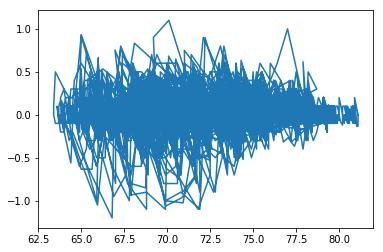

In [31]:
diff = no_action_data['t_next'] - no_action_data['t_in']
plt.plot(no_action_data['t_in'],diff)
diff.describe()